<a href="https://colab.research.google.com/github/virf96/Proyectos/blob/master/Consideraciones_Modelos_MA_Retornos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo de Medias Móviles

Este modelo a diferencia del modelo autorregresivo va a explicar a la serie de tiempo en función de los residuos en el periodo anterior.

Para este modelo **MA(1)** se leera como modelos de medias móviles con un retraso.

Pasos a seguir para encontrar el número de retrasos adecuados para la serie de tiempo:

$1.-$ Realizar la versión más simple del modelo

$2.-$ Complejizar el número de retrasos al menos hasta 8

$3.-$Analizar los significacia de los regresores y la probabilidad de la log verosimilitud

$4.-$Analizar los residuos de la serie temporal verificando que se cumpla una estacionalidad y comportamiento semejante al ruido blanco

$5.-$ Comparar los modelos y escoger el mejor

**Ahora veamos la forma más simple del modelo de medias móviles $MA(1):$ $x_{t}=c+\theta_{i}\epsilon_{t-1}+\epsilon_{t}$**, en donde:

$x_{t}:$ Observación en el periodo $t$

$c:$ es una constante

$\theta:$ Un parámetro  donde $-1<\theta<1$

$\epsilon_{t-1}:$ Residuo en el periodo $t-1$

$\epsilon_{t}:$ Residuo en el periodo $t$

**¿Como generamos los residuos?**

Los residuos serán el resultado de realizar la diferencia entre la observación estimado y la real en el periodo $t$.

$\epsilon=x_{t}-\hat{x_{t}}$

Para este modelo, la forma correcta de encontrar el número de retrasos correcto va a ser mediante el **ACF**, dado que el modelo de medias móviles no se basa en valores de la variable en periodos anteriores, en este caso nos interesa los efectos directos como los efectos inderectos. 

**Propiedades**

$\bullet$ MA(1)=AR($\infty$) Se cumple que un modelo de Medias Móviles con 1 retrasos es igual a un modelo autorregresivo con infinitos retrasos.



## Importing the relevant packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing the Data and Pre-processing 

In [ ]:
#Cargamos los datos
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/virf96/curso-series-temporales/master/2.%20Serie%20temporal%20en%20R%20y%20Python/Python/Index2018.csv") 
#Copiamos el df en una nueva variables
df_comp=raw_csv_data.copy()
#Convertimos la variables a formato fecha e indicamos que nuestra variable empieza con el día
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#Indexamos la fecha
df_comp.set_index("date", inplace=True)
#Indicamos que la frecuancia de los días es "busniess days"
df_comp=df_comp.asfreq('b')

In [ ]:
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [ ]:
#Contamos el número de na
df_comp.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [ ]:
#Llenamos los missings con el método front fill
df_comp=df_comp.fillna(method='ffill')

In [ ]:
#Renombramos la variable que vamos a utilizar
df_comp['market_value']=df_comp.ftse

In [ ]:
#Borramos las que no utilizaremos
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
#Determinamos el corte para el set de entrenamiento y de prueba
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [ ]:
df_comp.head()

,market_value
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


## The LLR Test

In [ ]:
#Definimos la función para el contraste de log verosimilitudes de los modelos que generaremos
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Creating Returns

In [ ]:
#Creamos los retornos de la variable para obtener una serie estacionaria, recordando que solo es la tasa de variación entre periodos
df['returns'] = df.market_value.pct_change(1)*100

In [ ]:
df.head()

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


## ACF for Returns

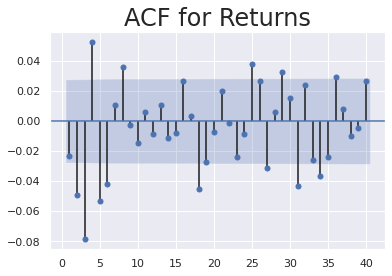

In [ ]:
#Analizamos el gráfico de autocorrelación
#Indicamos que no considere la primera fila dado que no hay tasa de variación entre los periodos
#Indicamos que no considere el primer retorno dado que no tendría sentido
#Y que lo haga pra 40 retrasos
#Observamos que no todos los retrasos son positivos a diferencia de con los precios, además de que varian mucho en magnitud
#Los primeros retornos son los más significativos
sgt.plot_acf(df.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns", size=24)
plt.show()

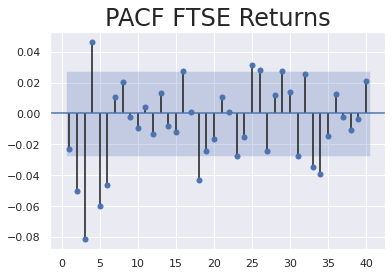

In [ ]:
#Gráfico de autocorrelación parcial
#Método por verosimilitud
#Observamos que es muy parecida al gráfico de autocorrelación
#Lo más recomendable será explorar más o menos 7 retrasos después de ese punto ya no serán de mucha ayuda los retrasos
sgt.plot_pacf(df.returns[1:], lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size=24)
plt.show()

## MA(1) for Returns

In [ ]:
#Modelo MA(1)
#A diferencia de los modelos AR, en el parametro "order=(0,1)" se pone de lado derecho el número de retrasos para que sea un modelo MA
model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))
#Ajustamos el modelo
results_ret_ma_1 = model_ret_ma_1.fit()
#Resumen del modelo, en este caso el primer retrasos no es significativo
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Thu, 16 Jul 2020   AIC                          15865.190
Time:                        20:33:27   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.086      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8549           +0.0000j           38.8549            0.0000
-----------------------------------------------------------------------------
"""

## Higher-Lag MA Models for Returns

In [ ]:
#Modelo MA(2)
model_ret_ma_2 = ARMA(df.returns[1:], order=(0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
#El primer y segundo retrasos si es significativo
#Contraste de log verosimilitudes es significante, por lo cuál nos quedamos con este modelo momentaneamente 
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_1, results_ret_ma_2)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 2)   Log Likelihood               -7922.864
Method:                       css-mle   S.D. of innovations              1.173
Date:                Thu, 16 Jul 2020   AIC                          15853.728
Time:                        20:44:00   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.239      0.215      -0.011       0.049
ma.L1.returns    -0.0327      0.014     -2.297      0.022      -0.061      -0.005
ma.L2.returns    -0.0502      0.014     

In [ ]:
#Modelo MA(3)
model_ret_ma_3 = ARMA(df.returns[1:], order=(0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
#El segundo y tercer retrasos si es significativo pero el primero no
#Contraste de log verosimilitudes es significante, por lo cuál nos quedamos con este modelo 
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_2, results_ret_ma_3)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 3)   Log Likelihood               -7904.317
Method:                       css-mle   S.D. of innovations              1.168
Date:                Thu, 16 Jul 2020   AIC                          15818.634
Time:                        20:45:57   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0203      0.014     -1.423      0.155      -0.048       0.008
ma.L2.returns    -0.0556      0.013     

In [ ]:
#Modelo MA(4)
model_ret_ma_4 = ARMA(df.returns[1:], order=[0,4])
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
#El segundo,tercero y cuarto retrasos son es significativos pero el primero no
#Contraste de log verosimilitudes es significante, por lo cuál nos quedamos con este modelo 
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_3, results_ret_ma_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 4)   Log Likelihood               -7898.773
Method:                       css-mle   S.D. of innovations              1.167
Date:                Thu, 16 Jul 2020   AIC                          15809.547
Time:                        20:46:46   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.305      0.192      -0.009       0.047
ma.L1.returns    -0.0203      0.014     -1.443      0.149      -0.048       0.007
ma.L2.returns    -0.0551      0.014     

In [ ]:
#Modelo MA(5)
model_ret_ma_5 = ARMA(df.returns[1:], order=[0,5])
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
#El segundo,tercero,cuarto y quinto retrasos son significativos pero el primero no
#Contraste de log verosimilitudes es significante, por lo cuál nos quedamos con este modelo 
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_4, results_ret_ma_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 5)   Log Likelihood               -7892.823
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 16 Jul 2020   AIC                          15799.645
Time:                        20:47:34   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0262      0.014     -1.851      0.064      -0.054       0.002
ma.L2.returns    -0.0497      0.014     

In [ ]:
#Modelo MA(6)
model_ret_ma_6 = ARMA(df.returns[1:], order=[0,6])
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
#El segundo,tercero,cuarto,quinto y sexto retrasos son significativos pero el primero no
#Contraste de log verosimilitudes es significante, por lo cuál nos quedamos con este modelo 
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_5, results_ret_ma_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 6)   Log Likelihood               -7889.221
Method:                       css-mle   S.D. of innovations              1.165
Date:                Thu, 16 Jul 2020   AIC                          15794.442
Time:                        20:48:14   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.430      0.153      -0.007       0.045
ma.L1.returns    -0.0237      0.014     -1.682      0.093      -0.051       0.004
ma.L2.returns    -0.0486      0.014     

In [ ]:
#Modelo MA(7)
model_ret_ma_7 = ARMA(df.returns[1:], order=[0,7])
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
#El segundo,tercero,cuarto,quinto y sexto retrasos son significativos pero el primero y septimo por lo cuál ya descartariamos este modelo
#Contraste de log verosimilitudes no es significante, por lo cuál descartamos este modelo
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_6, results_ret_ma_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 7)   Log Likelihood               -7889.046
Method:                       css-mle   S.D. of innovations              1.165
Date:                Thu, 16 Jul 2020   AIC                          15796.091
Time:                        20:49:37   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.418      0.156      -0.007       0.045
ma.L1.returns    -0.0247      0.014     -1.739      0.082      -0.052       0.003
ma.L2.returns    -0.0488      0.014     

In [ ]:
#Modelo MA(8)
model_ret_ma_8 = ARMA(df.returns[1:], order=[0,8])
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
#Podemos notar un comportamiento diferente ya que solo el primero y septimo valor no son significativos 
#En este caso lo importante es que el octavo retrasos es significativo
#La prueba de contraste es significaiva por lo cuál este modelo es mejor
#Como el gráfico de autocorrelación arroja que hasta el retrasos 18 encontraremos otro valor significativo es posible que este sea el mejor modelo para nuestro problema
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_7, results_ret_ma_8)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood               -7885.603
Method:                       css-mle   S.D. of innovations              1.164
Date:                Thu, 16 Jul 2020   AIC                          15791.205
Time:                        20:52:59   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.364      0.173      -0.008       0.046
ma.L1.returns    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.returns    -0.0495      0.014     

In [ ]:
#Contrastamos los 2 modelos ganadores
#La prueba es significativa, entonces nos quedamos con el modelo MA(8)
LLR_test(results_ret_ma_6, results_ret_ma_8, DF = 2)

0.027

## Residuals for Returns

In [ ]:
#Extraemos los residuos para analizar los supuestos 
df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

In [ ]:
#Caculamos la media de los residuos y calculamos la varianza redondeado a 3 decimales
print("The mean of the residuals is " + str(round(df.res_ret_ma_8.mean(),3)) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_8.var(),3)))

The mean of the residuals is -0.0
The variance of the residuals is 1.356


In [ ]:
#Como la varianza son las desviaciones al cuadrado utilizaremos la raíz para encontrar la desviación típica
#sigma
#Sabemos que un ruido blanco implica normalidad por lo que podemos usar la regla del 68,95 y 99.7 que indican que porcentaje de los datos se propaga a 1,2 o 3 desviaciones tipicas lejos de la media
#Por lo que esperamos que la mayoría de los retornos este entre -3*sigma y 3*sigma, es decir entre -3.5 y 3.5 
#Esto significa que en el peor de los casos podriamos tener variaciones de 7 puntos porcentuales entre la predicción y el valor real dado que |-3.5-3.5|=7
#Estas variaciones deben ser minimmizadas aún más dado que esta puede ser la brecha entre ganancias o perdidas
round(sqrt(df.res_ret_ma_8.var()),3)

1.164

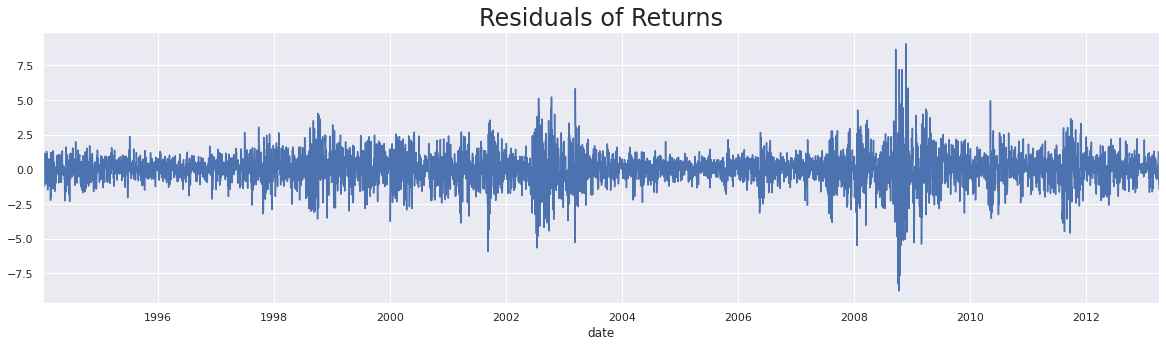

In [ ]:
#Veamos un gráfico de los residuos 
#La gráfica se asemeja a ruido blanco es decir no hay ningún patrón
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [ ]:
#Prueba de dicky fuller
#Como el p-value es menor que .05 se acepta que sea estacionaria
sts.adfuller(df.res_ret_ma_8[2:])

(-70.83581502434359,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '10%': -2.567076687880585,
  '5%': -2.8621161549128313},
 15684.052185059796)

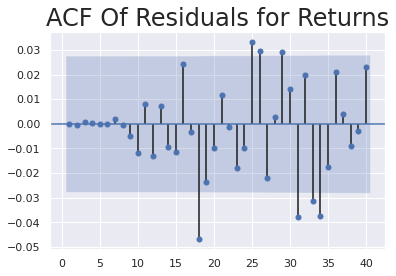

In [ ]:
#Veamos que el gráfico de autocorrelaciones aún muestra correlación, esto sugiere que quizas haya un mejor predictor pero esto pasaría hasta el retraso 18
sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

## Analicemos el otro modelo ganador MA(6)



In [ ]:
df['res_ret_ma_6'] = results_ret_ma_6.resid[1:]

In [ ]:
df.head()

,market_value,returns,res_ret_ma_8,res_ret_ma_6
date,,,,
1994-01-07,3445.98,NaN,NaN,NaN
1994-01-10,3440.58,-0.156704,NaN,NaN
1994-01-11,3413.77,-0.779229,-0.802111,-0.802083
1994-01-12,3372.02,-1.222988,-1.269464,-1.268789
1994-01-13,3360.01,-0.356166,-0.464780,-0.461319


In [ ]:
#Caculamos la media de los residuos y calculamos la varianza redondeado a 3 decimales
print("The mean of the residuals is " + str(round(df.res_ret_ma_6.mean(),3)) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_6.var(),3)))

The mean of the residuals is -0.0
The variance of the residuals is 1.357


In [ ]:
#Como la varianza son las desviaciones al cuadrado utilizaremos la raíz para encontrar la desviación típica
#sigma
#Sabemos que un ruido blanco implica normalidad por lo que podemos usar la regla del 68,95 y 99.7 que indican que porcentaje de los datos se propaga a 1,2 o 3 desviaciones tipicas lejos de la media
#Por lo que esperamos que la mayoría de los retornos este entre -3*sigma y 3*sigma, es decir entre -3.495 y 3.495 
#Esto significa que en el peor de los casos podriamos tener variaciones de 6.99 puntos porcentuales entre la predicción y el valor real dado que |-3.495-3.496|=6.99
#Este modelo es ligeramente mejor dado que las variaciones bajaron un poco
#Estas variaciones deben ser minimmizadas aún más dado que esta puede ser la brecha entre ganancias o perdidas
round(sqrt(df.res_ret_ma_6.var()),3)

1.165

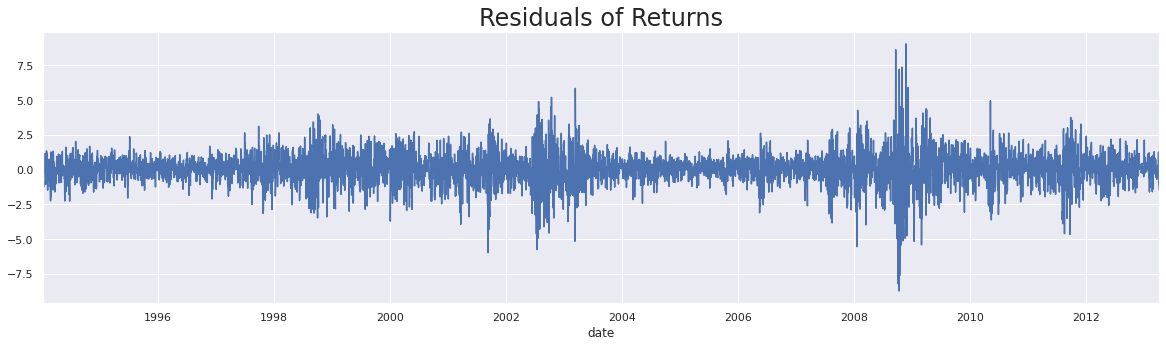

In [ ]:
#Veamos un gráfico de los residuos 
#La gráfica se asemeja a ruido blanco es decir no hay ningún patrón
df.res_ret_ma_6[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [ ]:
#Prueba de dicky fuller
#Como el p-value es menor que .05 se acepta que sea estacionaria
sts.adfuller(df.res_ret_ma_8[2:])

(-70.83581502434359,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '10%': -2.567076687880585,
  '5%': -2.8621161549128313},
 15684.052185059796)

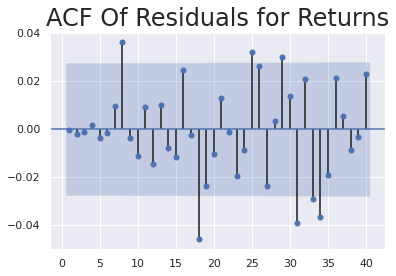

In [ ]:
#Veamos que el gráfico de autocorrelaciones aún muestra correlación, esto sugiere que quizas haya un mejor predictor considerando el retraso 8
sgt.plot_acf(df.res_ret_ma_6[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

## Normalización de precios

Cuando normalizamos la serie basicamente mapeamos cada valor del espacio muestral y lo convertimos en un porcentaje con respecto al primer valor del conjunto, esto nos va a dar una tasa.

De esta manera va a ser posible comparar diferentes series de tiempo.

Este proceso no afectara las propiedades de la serie, es decir, si no es estacionaria, esto no hará que lo sea.

In [ ]:
#Seleccionamos el primer valor de nuestra serie de precios y lo guardamos en "benchmark"
benchmark = df.market_value.iloc[0]
#Guardamos la variable normalizada en otra columna del df, dividimos ese valor entre cada uno de las observaciones y lo multipicamos por 100
df['norm'] = df.market_value.div(benchmark).mul(100)

In [ ]:
df.head()

,market_value,returns,res_ret_ma_8,res_ret_ma_6,norm
date,,,,,
1994-01-07,3445.98,NaN,NaN,NaN,100.000000
1994-01-10,3440.58,-0.156704,NaN,NaN,99.843296
1994-01-11,3413.77,-0.779229,-0.802111,-0.802083,99.065288
1994-01-12,3372.02,-1.222988,-1.269464,-1.268789,97.853731
1994-01-13,3360.01,-0.356166,-0.464780,-0.461319,97.505209


In [ ]:
#Verificamos que sea estacionaria
#Rechazamos que sea estacionaria dado que .05<.33
sts.adfuller(df['norm'])

(-1.9041551418836287,
 0.3301089327703105,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 19541.17381480549)

## Normalized Returns

In [ ]:
#Normalizamos los retornos
bench_ret = df.returns.iloc[1]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

In [ ]:
df.head()

,market_value,returns,res_ret_ma_8,res_ret_ma_6,norm,norm_ret
date,,,,,,
1994-01-07,3445.98,NaN,NaN,NaN,100.000000,NaN
1994-01-10,3440.58,-0.156704,NaN,NaN,99.843296,100.000000
1994-01-11,3413.77,-0.779229,-0.802111,-0.802083,99.065288,497.260711
1994-01-12,3372.02,-1.222988,-1.269464,-1.268789,97.853731,780.443046
1994-01-13,3360.01,-0.356166,-0.464780,-0.461319,97.505209,227.285567


In [ ]:
#En este caso los retornos si eran estacionarios, por lo cuál siguen siendo estacionarios
sts.adfuller(df.norm_ret[1:])

(-12.770265719497242,
 7.798058336038161e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '10%': -2.5670785949998973,
  '5%': -2.8621197374408225},
 80114.49116124898)

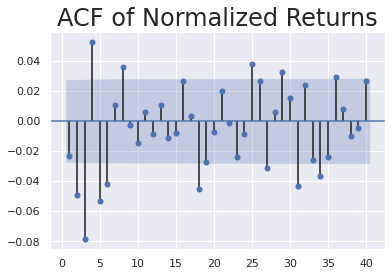

In [ ]:
#Lo correcto será utilizar los retornos normalizados para predecir las series temporales, dado ACF, este sugiere utilizar un MA(6) o MA(8)
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns",size=24)
plt.show()

In [ ]:
#Ajustamos el MA(8)
#Podemos ver que los resultados son los mismos con lo cuál podemos concluir que lo normalización no afecta la selección del modelo
model_norm_ret_ma_8 = ARMA(df.norm_ret[1:], order=(0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood              -40307.597
Method:                       css-mle   S.D. of innovations            742.822
Date:                Thu, 16 Jul 2020   AIC                          80635.194
Time:                        21:56:26   BIC                          80700.406
Sample:                    01-10-1994   HQIC                         80658.045
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      8.846     -1.354      0.176     -29.311       5.364
ma.L1.norm_ret    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.norm_ret    -0.0495      0.014     -3.514      0.000      -0.077      -0.022
ma.L3.norm_ret    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.norm_ret     0.0488      0.014      3.440      0.001       0.021       0.077
ma.L5.norm_ret    -0.0518      0.014     -3.634      0.000      -0.080      -0.024
ma.L6.norm_ret    -0.0402      0.014     -2.787      0.005      -0.068      -0.012
ma.L7.norm_ret     0.0084      0.014      0.587      0.557      -0.020       0.036
ma.L8.norm_ret     0.0366      0.014      2.626      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4716           -0.4282j            1.5326           -0.0451
MA.2            1.4716           +0.4282j            1.5326            0.0451
MA.3            0.5944           -1.3169j            1.4448           -0.1825
MA.4            0.5944           +1.3169j            1.4448            0.1825
MA.5           -0.7318           -1.2736j            1.4689           -0.3330
MA.6           -0.7318           +1.2736j            1.4689            0.3330
MA.7           -1.4485           -0.6983j            1.6081           -0.4285
MA.8           -1.4485           +0.6983j            1.6081            0.4285
-----------------------------------------------------------------------------
"""

In [ ]:
#Guardamos los residuos
df['res_norm_ret_ma_8'] = results_norm_ret_ma_8.resid[1:]

In [ ]:
#Aceptamos la estacionalidad
sts.adfuller(df.res_norm_ret_ma_8[2:])

(-70.83581823007648,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '10%': -2.567076687880585,
  '5%': -2.8621161549128313},
 80088.85897128218)

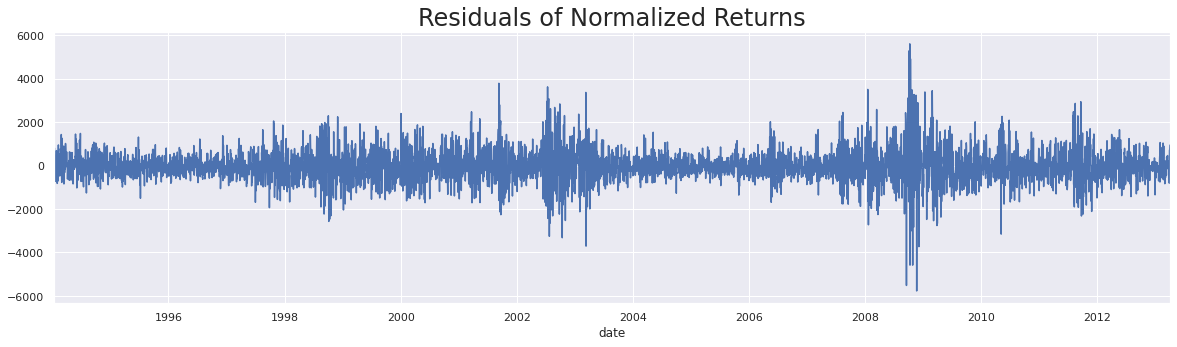

In [ ]:
df.res_norm_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals of Normalized Returns",size=24)
plt.show()

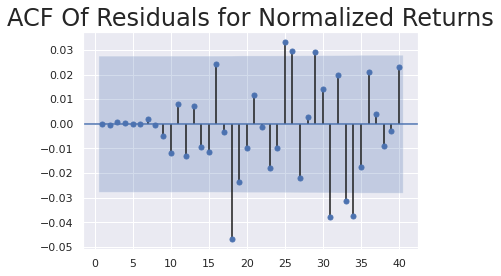

In [ ]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Normalized Returns",size=24)
plt.show()

## MA Models For Prices

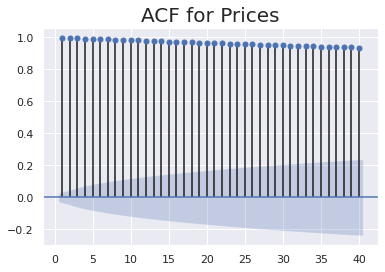

In [ ]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size=20)
plt.show()

In [ ]:
model_ma_1 = ARMA(df.market_value, order=(0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(0, 1)   Log Likelihood              -38629.000
Method:                       css-mle   S.D. of innovations            530.756
Date:                Tue, 21 Apr 2020   AIC                          77264.000
Time:                        10:33:21   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6652     14.660    347.192      0.000    5060.933    5118.397
ma.L1.market_value     0.9573      0.003    335.561      0.000       0.952       0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0446           +0.0000j            1.0446            0.5000
-----------------------------------------------------------------------------
"""